## Introduction

$$
\Delta y_t = \alpha \beta^T y_{t-1} + \Gamma_1 \Delta y_{t-1} + \dots + \Gamma_{p-1} \Delta y_{t-p+1} + \epsilon_t 
$$

### Imports

In [1]:
import pandas as pd
# pd.options.display.float_format = "{:.2f}".format
import numpy as np
from matplotlib import pyplot as plt

from statsmodels.tsa.vector_ar.vecm import VECM, select_coint_rank, select_order

### Data Import

In [111]:
nome1 = 'AMZN'
nome2 = 'GOOG'

AMZN = pd.read_csv(fr'data\{nome1}.csv', index_col=0)
AMZN.index = pd.to_datetime(AMZN.index)

GOOG = pd.read_csv(fr'data\{nome2}.csv', index_col=0)
GOOG.index = pd.to_datetime(GOOG.index)

df_pair = pd.concat((np.log(AMZN.Close.rename(nome1)),np.log(GOOG.Close.rename(nome2))), axis=1)
df_pair = df_pair.dropna()

# df_pair = pd.concat((np.log(GOOG.Close.rename(nome2)), np.log(AMZN.Close.rename(nome1))), axis=1)
# df_pair = df_pair.dropna()


Text(0, 0.5, 'USD')

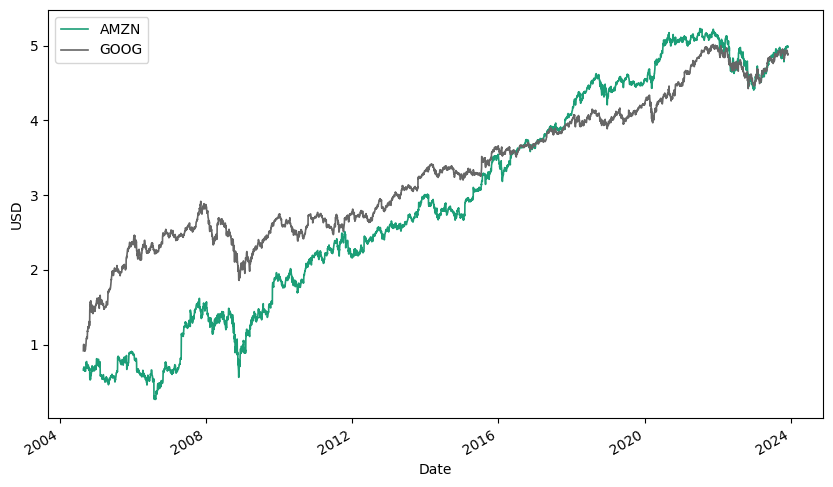

In [112]:
import datetime


df_pair.plot(figsize=(10,6),  linewidth=1.2, cmap= plt.cm.Dark2)
# plt.axvline(datetime.datetime(2022, 1, 1), color='red')
plt.ylabel('USD')
# plt.tight_layout()

Text(0, 0.5, 'log(USD)')

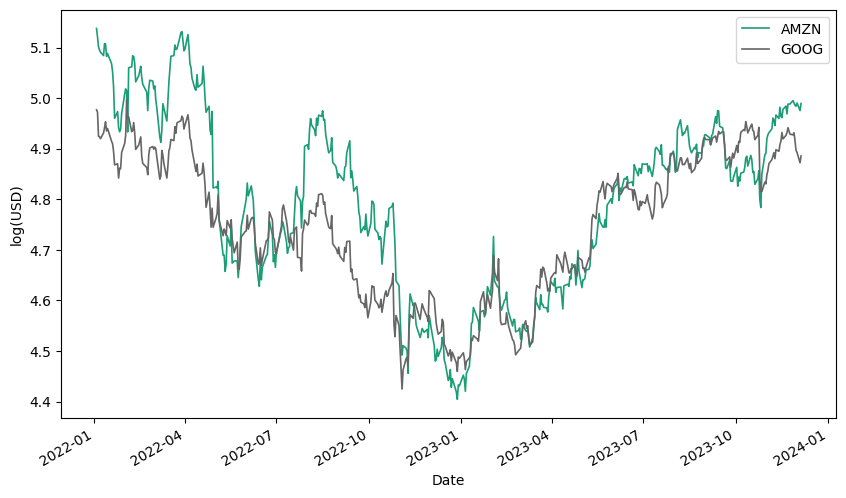

In [114]:
df_pair = df_pair['2022':]

df_pair.plot(figsize=(10,6),  linewidth=1.2, colormap= plt.cm.Dark2)
plt.ylabel('log(USD)')

In [115]:
###### Check Stationarity ###########
from utils import adf_test, kpss_test

for i in df_pair.columns:
    adf = adf_test(df_pair['AMZN'])
    kpss = kpss_test(df_pair['GOOG'])
    
kpss


,Test_Type,Test_Statistic,Critical_Value,p-value,Used_lags,Conclusion
0,Constant,0.874941,0.463,0.01,12,Non-Stationary
1,Constant/Trend,0.865562,0.146,0.01,12,Non-Stationary


In [116]:
adf

,Test_Type,Test_Statistic,Critical_Value,p-value,Used_lags,Conclusion
0,None,-0.324435,-1.941570,0.566579,0,Non-Stationary
1,Constant,-2.069578,-2.867543,0.256922,0,Non-Stationary
2,Constant/Trend,-1.817631,-3.419619,0.696195,0,Non-Stationary


In [117]:
from utils import adf_test, kpss_test

for i in df_pair.columns:
    diff_adf = adf_test(df_pair['GOOG'].diff().dropna())
    diff_kpss = kpss_test(df_pair['GOOG'].diff().dropna())

In [118]:
diff_kpss

,Test_Type,Test_Statistic,Critical_Value,p-value,Used_lags,Conclusion
0,Constant,0.252073,0.463,0.1,5,Stationary
1,Constant/Trend,0.036955,0.146,0.1,5,Stationary


In [119]:
import warnings
warnings.filterwarnings('ignore')

order = select_order(df_pair, deterministic='n', maxlags=10)
order.selected_orders

{'aic': 3, 'bic': 0, 'hqic': 0, 'fpe': 3}

In [120]:
# Estatística do Traço
rank_test = select_coint_rank(endog=df_pair,det_order= -1,k_ar_diff=3, method='trace',
                              signif=0.05)
rank_test.summary()
# rank_test.rank

r_0,r_1,test statistic,critical value
0,2,13.23,12.32
1,2,0.003695,4.130


In [121]:
# Estatística do Máximo Autovalor
rank_test = select_coint_rank(endog=df_pair,det_order= 0,k_ar_diff=4, method='maxeig',
                              signif=0.05)
rank_test.summary()
# rank_test.rank

r_0,r_1,test statistic,critical value
0,1,15.11,14.26
1,2,3.655,3.841


In [122]:
vecm = VECM(df_pair, coint_rank=1, # 1 relação de cointegração de acordo com o teste de Johansen
            k_ar_diff=3, #3 lags autoregressivos
            deterministic = 'co' #constante
            ).fit()

In [123]:
# Teste de Autocorrelação dos Resíduos
ljungbox = vecm.test_whiteness()
ljungbox.summary()

Test statistic,Critical value,p-value,df
21.50,38.89,0.715,26


In [124]:
# Teste de Normalidade dos Resíduos
ljungbox = vecm.test_normality()
ljungbox.summary()

Test statistic,Critical value,p-value,df
600.1,9.488,0.000,4


In [125]:
vecm.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
const,-0.0376,0.012,-3.138,0.002,-0.061,-0.014
L1.AMZN,0.1107,0.063,1.759,0.079,-0.013,0.234
L1.GOOG,-0.2092,0.078,-2.699,0.007,-0.361,-0.057
L2.AMZN,0.0048,0.062,0.077,0.939,-0.118,0.127
L2.GOOG,0.0286,0.077,0.373,0.709,-0.122,0.179
L3.AMZN,0.1253,0.062,2.011,0.044,0.003,0.247
L3.GOOG,-0.2255,0.077,-2.918,0.004,-0.377,-0.074
,coef,std err,z,P>|z|,[0.025,0.975]
const,-0.0069,0.010,-0.692,0.489,-0.026,0.013
L1.AMZN,0.0353,0.052,0.679,0.497,-0.067,0.137


$$ 
 \Delta p_{t}^{Amzn} = -0.037 -0.051(p_{t-1}^{Amzn} - 1.1639p_{t-1}^{Goog}) + \dots
$$
 $$\Delta p_{t}^{Goog} = -0.069 -0.009(p_{t-1}^{Amzn} - 1.1639p_{t-1}^{Goog}) + \dots$$



In [126]:
spread = df_pair['AMZN'] -1.1639*df_pair['GOOG']

<AxesSubplot: xlabel='Date'>

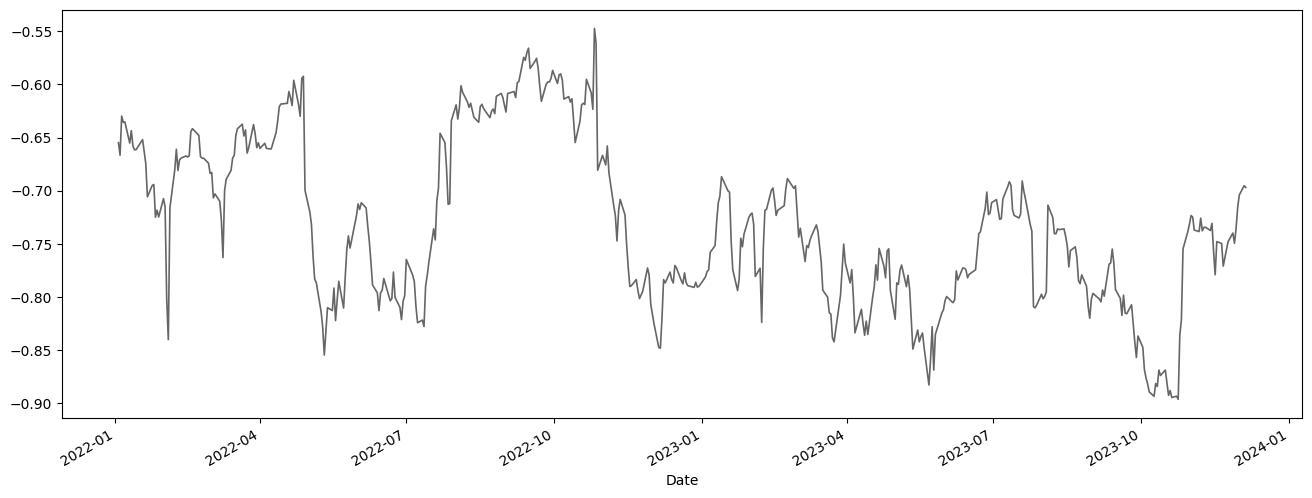

In [128]:
spread.plot(figsize=(16,6),  linewidth=1.2, cmap= plt.cm.Dark2_r)

<AxesSubplot: xlabel='Date'>

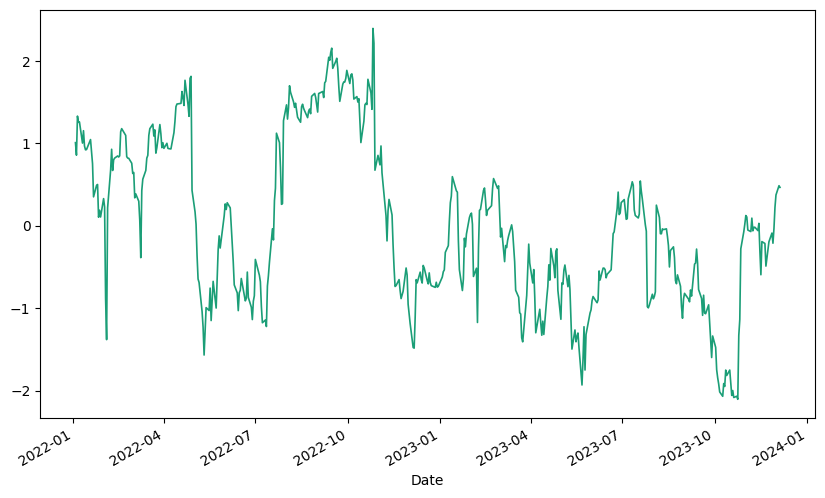

In [129]:
std_spread = (spread - spread.mean())/spread.std()
std_spread.plot(figsize=(10,6),  linewidth=1.2, cmap= plt.cm.Dark2)

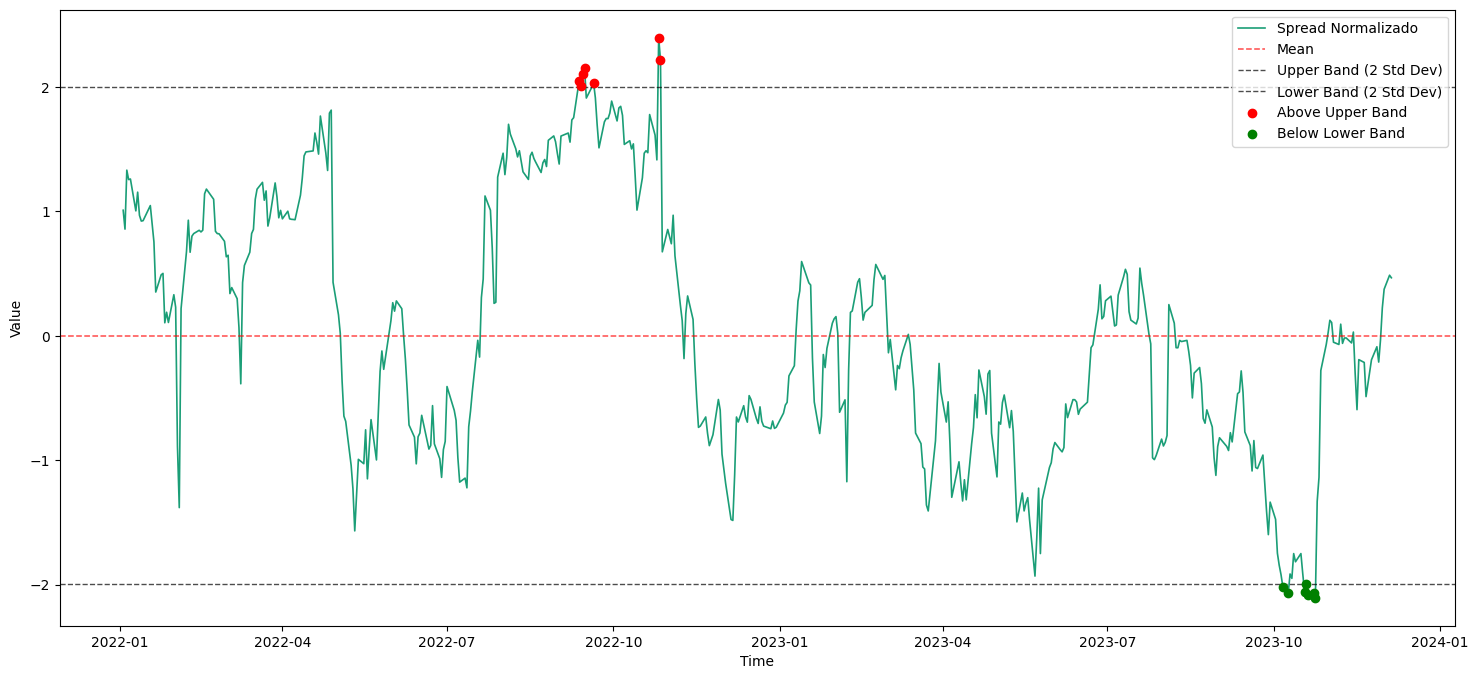

In [92]:
mean_value = np.mean(std_spread)
std_dev = np.std(std_spread)

# Define the upper and lower bands based on the standard deviation
upper_band = mean_value + 2 * std_dev
lower_band = mean_value - 2 * std_dev

# Identify values above and below bands
above_upper_band = std_spread > upper_band
below_lower_band = std_spread < lower_band


plt.figure(figsize=(18,8))
cmap= plt.cm.Dark2([0,0.75])

# Plot the time series
plt.plot(std_spread,label='Spread Normalizado', color=cmap[0], linewidth=1.2,zorder=-1)

# Plot the mean line
plt.axhline(y=mean_value, color='r', linestyle='--', label='Mean', linewidth=1.1, alpha=0.7)

# Plot the upper and lower bands
plt.axhline(y=upper_band, color='k', linestyle='--', label='Upper Band (2 Std Dev)', linewidth=1.0, alpha=0.7)
plt.axhline(y=lower_band, color='k', linestyle='--', label='Lower Band (2 Std Dev)', linewidth=1.0, alpha=0.7)

# Mark points above and below bands
plt.scatter(std_spread[above_upper_band].index, std_spread[above_upper_band], color='red', label='Above Upper Band', zorder=2)
plt.scatter(std_spread[below_lower_band].index, std_spread[below_lower_band], color='green', label='Below Lower Band', zorder=2)

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

plt.show()


In [21]:
def calculate_returns(x:pd.Series):
    
    log_returns = np.log(x) - np.log(x.shift(1))
    
    return log_returns

In [107]:
AMZN_level = AMZN['Close']['2022':]

df_sinais = pd.concat((std_spread.rename('SPREAD'),AMZN_level), axis=1)
df_sinais['Sell'] = np.where(std_spread > upper_band, 1, 0)
df_sinais['Buy'] = np.where(std_spread < lower_band, 1, 0)
df_sinais['Sell'] = df_sinais['Sell'].diff()
df_sinais['Buy'] = df_sinais['Buy'].diff()
df_sinais.dropna(inplace=True)


In [108]:
df_sinais[(df_sinais['Buy']==1) | (df_sinais['Sell']==1)]

,SPREAD,Close,Sell,Buy
Date,,,,
2022-09-12,2.044976,136.449997,1.0,0.0
2022-09-20,2.032894,122.190002,1.0,0.0
2022-10-26,2.395407,115.660004,1.0,0.0
2023-10-06,-2.016086,127.959999,0.0,1.0
2023-10-18,-2.058380,128.130005,0.0,1.0


In [109]:
def simulate_trades(df):
    trades = []
    open_trades = []
    
    for index, row in df.iterrows():
        if row['Buy'] == 1:
            new_trade = {'type':'buy', 'entry_date': index, 'entry_price': row['Close'],'entry_spread': row['SPREAD']}
            open_trades.append(new_trade)
        elif row['Sell'] == 1:
            new_trade = {'type':'sell', 'entry_date': index,'entry_price': row['Close'], 'entry_spread': row['SPREAD']}
            open_trades.append(new_trade)

    for trade in open_trades:

        df_trade = df.loc[trade['entry_date']:]

        for index, row in df_trade.iterrows():
            if row['SPREAD'] * trade['entry_spread'] < 0:
                trade['exit_date'] = index
                trade['exit_price'] = row['Close']
                trade['exit_spread'] = row['SPREAD']
                
                if trade['type'] == 'buy':
                    # trade['return (%)'] = df_trade.loc[:trade['exit_date'], 'Returns'].cumsum().iloc[-1]*100
                    trade['return (%)'] = ( trade['exit_price'] - trade['entry_price'])/ trade['entry_price']*100
                elif trade['type'] == 'sell':
                    # trade['return (%)'] = -df_trade.loc[:trade['exit_date'], 'Returns'].cumsum().iloc[-1]*100
                    trade['return (%)'] = ( trade['entry_price'] -  trade['exit_price'])/ trade['entry_price']*100
                break
            
        trades.append(trade)

    return pd.DataFrame(trades).sort_values('entry_date', ascending=True)

# Example usage:
# Assuming your DataFrame is named 'df'
trades_df = simulate_trades(df_sinais)
trades_df


,type,entry_date,entry_price,entry_spread,exit_date,exit_price,exit_spread,return (%)
0,sell,2022-09-12,136.449997,2.044976,2022-11-09,86.139999,-0.183424,36.870648
1,sell,2022-09-20,122.190002,2.032894,2022-11-09,86.139999,-0.183424,29.503235
2,sell,2022-10-26,115.660004,2.395407,2022-11-09,86.139999,-0.183424,25.523088
3,buy,2023-10-06,127.959999,-2.016086,2023-10-31,133.089996,0.020424,4.009063
4,buy,2023-10-18,128.130005,-2.058380,2023-10-31,133.089996,0.020424,3.871062


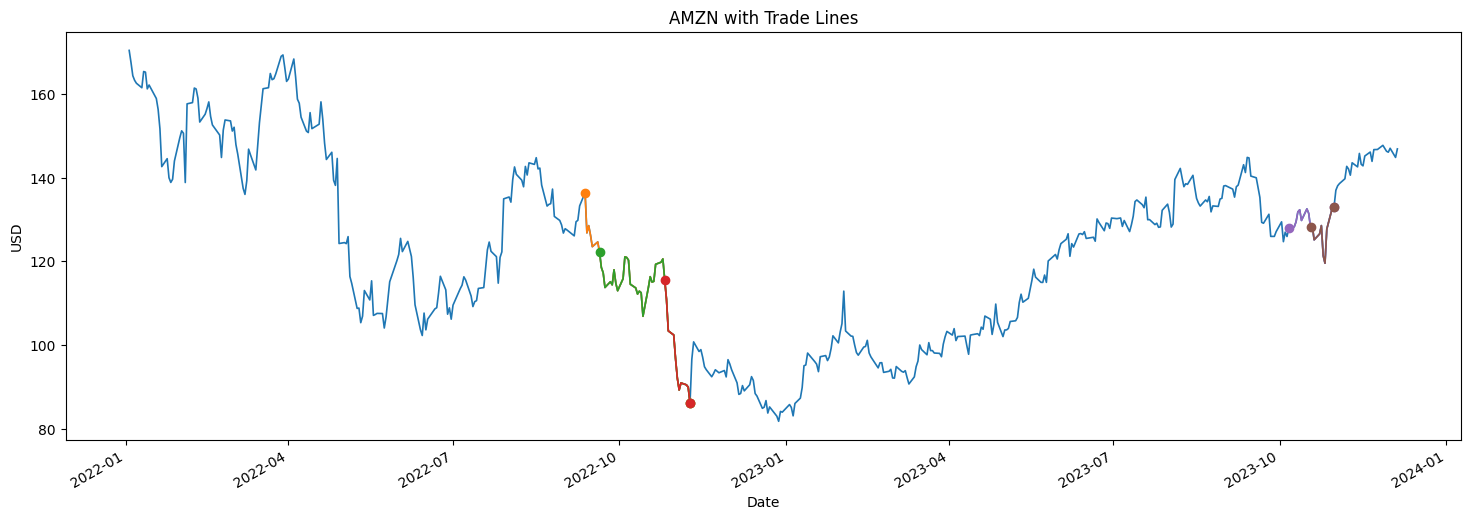

In [144]:
import matplotlib.pyplot as plt

# Assuming AMZN is your DataFrame with 'Close' column
AMZN['Close']['2022':].plot(figsize=(18,6),  linewidth=1.2)

# Iterate through each row in trades_df and plot a line for each trade
for index, trade in trades_df.iterrows():
    
    AMZN['Close'][trade['entry_date']:trade['exit_date']].plot(marker='o',  markevery=[0,-1], figsize=(18,6),  linewidth=1.2)
    

plt.xlabel('Date')
plt.ylabel('USD')
plt.title('AMZN with Trade Lines')
plt.show()


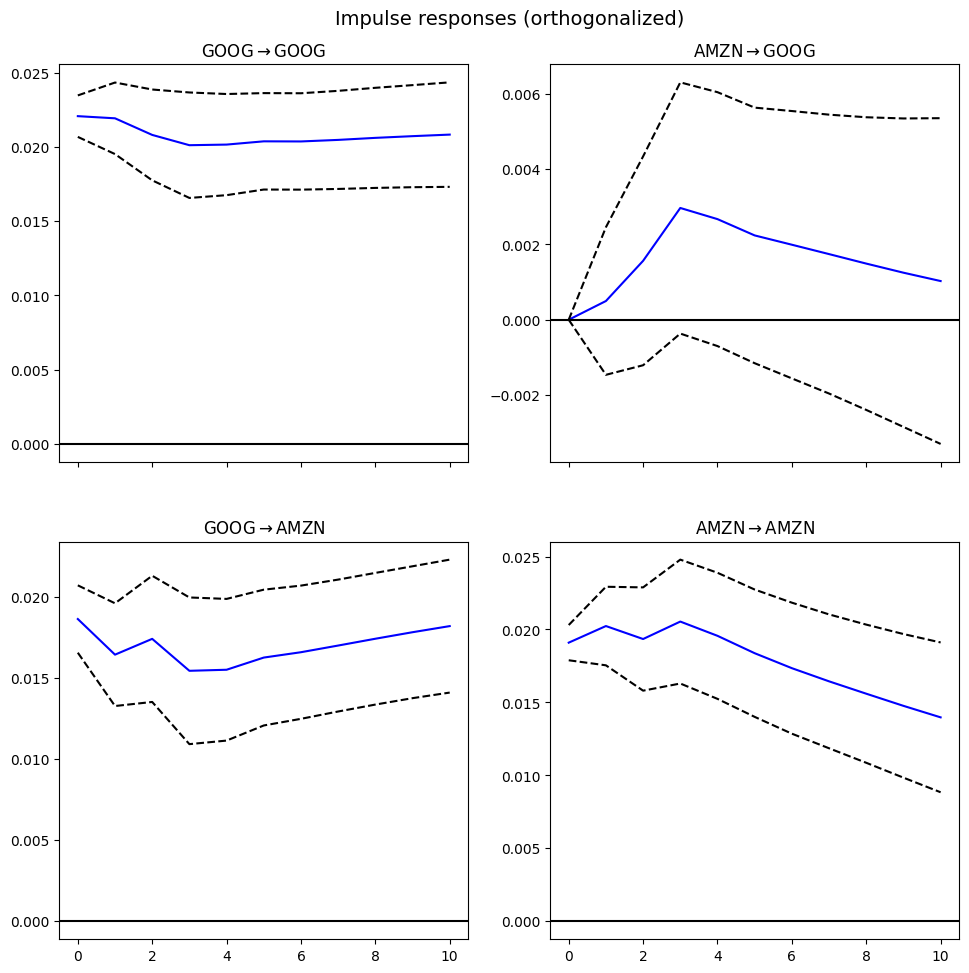

In [110]:
irf = vecm.irf()

_=irf.plot(orth=True)

In [96]:
granger_amzn = vecm.test_granger_causality(causing="AMZN", caused='GOOG', signif=0.05)
granger_amzn.summary()

Test statistic,Critical value,p-value,df
1.250,2.381,0.288,"(4, 936)"


In [97]:
granger_goog = vecm.test_granger_causality(causing="GOOG",caused='AMZN', signif=0.05)
granger_goog.summary()

Test statistic,Critical value,p-value,df
2.315,2.381,0.056,"(4, 936)"
